# 準備

## Import 

In [1]:
# !pip install albumentations

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision
import numpy as np
import gc  
from albumentations import (
    Compose, Normalize, Resize,
    RandomResizedCrop, HorizontalFlip,
    RandomBrightnessContrast, ShiftScaleRotate
)
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
import pytz
from tqdm import tqdm

In [3]:
class Config:
    patience=10
    num_epochs=80
    mixup_epochs=5
    batch_size=32
    
config = Config()

In [4]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

# Use a chosen seed
set_seed(42)

In [5]:
# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# Get current date and time in JST
jst = pytz.timezone('Asia/Tokyo')
current_datetime = datetime.now(jst)
# Get current date and time
formatted_datetime = current_datetime.strftime('%Y%m%d%H%M%S')

print(formatted_datetime)

20230820104648


## Path

## def

In [7]:
def view_img(dir_name, file_name):
    
    info_table = pd.read_csv(f'../data/{dir_name}.csv', header=None, names=['name', 'label'])
    target_label = info_table[info_table['name']==f'{file_name}']['label']
    
    # # Display the image
    img = Image.open(f'../data/{dir_name}/'+file_name)
    # img = Image.open('../data/train_1/'+f'train_1811.png')
    
    plt.title(file_name)
    plt.imshow(img)
    plt.show()

    print("Label:", target_label.values[0])  # values[0] is used to get the first value if multiple rows match the condition
    print("Size of the image:", img.size)


# EDA

In [8]:
# df = pd.read_csv('../data/train_1.csv', header=None, names=['name', 'label'])
# df.head(3)

In [9]:
# random_idx = random.choice(range(len(df)))
# file_name = f'train_{random_idx}.png'
# dir_name = 'train_1'

# view_img(dir_name, file_name)

In [10]:
# # Directory to search
# directory = "../data/train_1/"

# # Maximum file size in bytes (40K in this case)
# max_size = 40 * 1024

# # Get list of files in the directory and subdirectories
# file_list = []

# for directory in ["../data/train_1/","../data/train_2/","../data/train_3/","../data/train_4/"]:
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             full_path = os.path.join(foldername, filename)
#             if os.path.getsize(full_path) <= max_size:
#                 file_list.append(full_path)

In [11]:
# file_list

In [12]:
# file_name = f'train_1474.png'
# dir_name = 'train_3'

# view_img(dir_name, file_name)

In [13]:
# # Get image paths for label 0 and 1
# image_paths_0 = df[df['label'] == 0]['name'].values
# image_paths_1 = df[df['label'] == 1]['name'].values

# # Function to display images
# def display_images(image_paths, title):
#     plt.figure(figsize=(10,10))
#     for i in range(9):  # display 9 images
#         plt.subplot(3,3,i+1)
#         img = Image.open(image_paths[i])
#         plt.imshow(img)
#         plt.title(title)
#         plt.axis('off')
#     plt.show()

# # Display images for label 0 and 1
# display_images('../data/train_1/'+ image_paths_0, 'label_0')
# display_images('../data/train_1/'+ image_paths_1, 'label_1')

# ## 画像が欠損しているデータもあり

In [14]:
# df.groupby('label')['name'].count()

# ベースモデル

## 学習フェーズ

### 関数

In [15]:
def get_transforms():
    transforms_dict = {
        'train': Compose([
            RandomResizedCrop(512, 512),
            HorizontalFlip(),
            RandomBrightnessContrast(),
            ShiftScaleRotate(),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
        'valid': Compose([
            Resize(512, 512),
            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ]),
    }
    return transforms_dict


def load_datasets(df, root_dir, transforms_dict):
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    datasets = {
        'train': CustomImageDataset(train_df, root_dir, transform=transforms_dict['train']),
        'valid': CustomImageDataset(valid_df, root_dir, transform=transforms_dict['valid'])
    }
    return datasets


def get_dataloaders(datasets, batch_size):
    dataloaders = {
        'train': DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False)
    }
    return dataloaders

    
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        label = self.df.iloc[idx, 1]
        if self.transform:
            transformed = self.transform(image=image)  # Apply the transformations
            image = transformed["image"]
        return image, label
    
def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            


    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
    
    
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{formatted_datetime}_{file_name}.pth')
    print('Finished Training')
          

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        
def train_model_mixup_el_stop(dataloaders, model, criterion, optimizer, num_epochs, file_name, mixup_epochs, patience):
    early_stopping = EarlyStopping(patience=patience, path=f'../models/{formatted_datetime}_{file_name}.pth',verbose=True)
    stop_training = False  # 早期停止フラグ
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Mixupを適用する条件
                    if phase == 'train' and epoch < mixup_epochs:
                        inputs, labels_a, labels_b, lmd = mixup_data(inputs, labels)
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lmd)
                        _, preds = torch.max(outputs, 1)
                        # Mixupでの正確さの計算
                        correct_predictions += lmd * torch.sum(preds == labels_a).item() + (1.0 - lmd) * torch.sum(preds == labels_b).item()
                    else:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # 通常の正確さの計算
                        correct_predictions += torch.sum(preds == labels.data).item()
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'valid':
                early_stopping(-epoch_acc, model)
                if early_stopping.early_stop:
                    print("Early stopping")
                    stop_training = True
                    break

        if stop_training:
            break
            
    print('Finished Training')

### 実行

In [17]:
for ds in ['train_1','train_2','train_3','train_4']:

    # Load labels from csv
    df = pd.read_csv(f'../data/{ds}.csv', header=None, names=['name', 'label'])
    
    # 40kB以下の空白画像をdfから削除
    file_list = []
    for foldername, subfolders, filenames in os.walk(os.path.join("../data/",ds)):
        for filename in filenames:
            full_path = os.path.join(foldername, filename)
            max_size = 40 * 1024
            if os.path.getsize(full_path) <= max_size:
                file_list.append(filename)
    df = df[~df['name'].isin(file_list)]
    
    # Get transforms
    transforms_dict = get_transforms()

    # Load datasets
    datasets = load_datasets(df, f'../data/{ds}/', transforms_dict)

    # Create dataloaders
    dataloaders = get_dataloaders(datasets, batch_size=32)

    # Define model
    model = torchvision.models.resnet34()
    model.fc = nn.Linear(model.fc.in_features, 2) 
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
#     train_model(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds)
#     train_model_mixup(dataloaders, model, criterion, optimizer, num_epochs=15, file_name=ds, mixup_epochs=10)
    train_model_mixup_el_stop(
        dataloaders,
        model, 
        criterion,
        optimizer,
        num_epochs=config.num_epochs,
        file_name=ds, 
        mixup_epochs=config.mixup_epochs,
        patience=config.patience
    )

del df
del dataloaders
gc.collect()

Epoch 1/80
----------


100%|█████████████████████████████████████████| 124/124 [03:51<00:00,  1.87s/it]


train Loss: 0.7057 Acc: 0.5732


100%|███████████████████████████████████████████| 31/31 [00:25<00:00,  1.20it/s]


valid Loss: 0.6794 Acc: 0.5247
Validation loss decreased (inf --> -0.524723).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 124/124 [03:41<00:00,  1.79s/it]


train Loss: 0.6672 Acc: 0.6158


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.6421 Acc: 0.6519
Validation loss decreased (-0.524723 --> -0.651867).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 124/124 [03:41<00:00,  1.78s/it]


train Loss: 0.6587 Acc: 0.6242


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.6981 Acc: 0.5015
EarlyStopping counter: 1 out of 10
Epoch 4/80
----------


100%|█████████████████████████████████████████| 124/124 [03:41<00:00,  1.79s/it]


train Loss: 0.6488 Acc: 0.6253


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.6127 Acc: 0.6337
EarlyStopping counter: 2 out of 10
Epoch 5/80
----------


100%|█████████████████████████████████████████| 124/124 [03:41<00:00,  1.78s/it]


train Loss: 0.6356 Acc: 0.6453


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.6416 Acc: 0.6458
EarlyStopping counter: 3 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5873 Acc: 0.6838


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4962 Acc: 0.7619
Validation loss decreased (-0.651867 --> -0.761857).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5525 Acc: 0.7114


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.5121 Acc: 0.7477
EarlyStopping counter: 1 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5641 Acc: 0.7025


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4940 Acc: 0.7669
Validation loss decreased (-0.761857 --> -0.766902).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.77s/it]


train Loss: 0.5499 Acc: 0.7230


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.8830 Acc: 0.6044
EarlyStopping counter: 1 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5486 Acc: 0.7119


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.25it/s]


valid Loss: 0.6527 Acc: 0.6044
EarlyStopping counter: 2 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5451 Acc: 0.7260


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4305 Acc: 0.8163
Validation loss decreased (-0.766902 --> -0.816347).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5158 Acc: 0.7475


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4834 Acc: 0.7699
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5230 Acc: 0.7465


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.5723 Acc: 0.6821
EarlyStopping counter: 2 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5218 Acc: 0.7356


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.25it/s]


valid Loss: 0.4992 Acc: 0.7497
EarlyStopping counter: 3 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4902 Acc: 0.7601


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.5296 Acc: 0.7286
EarlyStopping counter: 4 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.5176 Acc: 0.7371


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4820 Acc: 0.7760
EarlyStopping counter: 5 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4938 Acc: 0.7601


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.5297 Acc: 0.7296
EarlyStopping counter: 6 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4897 Acc: 0.7631


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.3874 Acc: 0.8295
Validation loss decreased (-0.816347 --> -0.829465).  Saving model ...
Epoch 19/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4985 Acc: 0.7551


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4192 Acc: 0.8244
EarlyStopping counter: 1 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4898 Acc: 0.7596


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.5073 Acc: 0.7538
EarlyStopping counter: 2 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4537 Acc: 0.7886


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.4384 Acc: 0.7952
EarlyStopping counter: 3 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 124/124 [03:40<00:00,  1.78s/it]


train Loss: 0.4750 Acc: 0.7684


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.3164 Acc: 0.8749
Validation loss decreased (-0.829465 --> -0.874874).  Saving model ...
Epoch 23/80
----------


100%|█████████████████████████████████████████| 124/124 [03:39<00:00,  1.77s/it]


train Loss: 0.4557 Acc: 0.7884


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.7882 Acc: 0.6902
EarlyStopping counter: 1 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4798 Acc: 0.7745


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.4197 Acc: 0.7962
EarlyStopping counter: 2 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4356 Acc: 0.8013


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.5020 Acc: 0.7477
EarlyStopping counter: 3 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.4504 Acc: 0.7924


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3683 Acc: 0.8517
EarlyStopping counter: 4 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4363 Acc: 0.7970


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3589 Acc: 0.8496
EarlyStopping counter: 5 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4302 Acc: 0.8030


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4046 Acc: 0.8153
EarlyStopping counter: 6 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4468 Acc: 0.7886


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3934 Acc: 0.8174
EarlyStopping counter: 7 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4215 Acc: 0.7992


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3452 Acc: 0.8698
EarlyStopping counter: 8 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4300 Acc: 0.7965


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3154 Acc: 0.8779
Validation loss decreased (-0.874874 --> -0.877901).  Saving model ...
Epoch 32/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3987 Acc: 0.8189


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4218 Acc: 0.8194
EarlyStopping counter: 1 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.4361 Acc: 0.8023


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.2973 Acc: 0.8829
Validation loss decreased (-0.877901 --> -0.882947).  Saving model ...
Epoch 34/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4031 Acc: 0.8131


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3437 Acc: 0.8618
EarlyStopping counter: 1 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4144 Acc: 0.8096


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.2979 Acc: 0.8759
EarlyStopping counter: 2 out of 10
Epoch 36/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4084 Acc: 0.8169


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.5381 Acc: 0.7649
EarlyStopping counter: 3 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4060 Acc: 0.8154


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3746 Acc: 0.8325
EarlyStopping counter: 4 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3862 Acc: 0.8280


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4302 Acc: 0.8012
EarlyStopping counter: 5 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.3867 Acc: 0.8222


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.2846 Acc: 0.8840
Validation loss decreased (-0.882947 --> -0.883956).  Saving model ...
Epoch 40/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3921 Acc: 0.8268


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.8839 Acc: 0.7205
EarlyStopping counter: 1 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4054 Acc: 0.8217


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3078 Acc: 0.8829
EarlyStopping counter: 2 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3991 Acc: 0.8182


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 1.6672 Acc: 0.6559
EarlyStopping counter: 3 out of 10
Epoch 43/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3831 Acc: 0.8260


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3929 Acc: 0.8073
EarlyStopping counter: 4 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3934 Acc: 0.8237


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3589 Acc: 0.8567
EarlyStopping counter: 5 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3938 Acc: 0.8265


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.2992 Acc: 0.8789
EarlyStopping counter: 6 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3684 Acc: 0.8328


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3877 Acc: 0.8345
EarlyStopping counter: 7 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3644 Acc: 0.8386


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.2933 Acc: 0.8789
EarlyStopping counter: 8 out of 10
Epoch 48/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3735 Acc: 0.8326


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.2738 Acc: 0.8819
EarlyStopping counter: 9 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3727 Acc: 0.8338


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3677 Acc: 0.8426
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
Epoch 1/80
----------


100%|█████████████████████████████████████████| 124/124 [03:44<00:00,  1.81s/it]


train Loss: 0.6784 Acc: 0.5703


100%|███████████████████████████████████████████| 31/31 [00:25<00:00,  1.23it/s]


valid Loss: 0.8494 Acc: 0.5943
Validation loss decreased (inf --> -0.594349).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.77s/it]


train Loss: 0.6443 Acc: 0.6289


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.6057 Acc: 0.6801
Validation loss decreased (-0.594349 --> -0.680121).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.77s/it]


train Loss: 0.6530 Acc: 0.6198


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.8168 Acc: 0.6024
EarlyStopping counter: 1 out of 10
Epoch 4/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.6423 Acc: 0.6274


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.5808 Acc: 0.7296
Validation loss decreased (-0.680121 --> -0.729566).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 124/124 [03:39<00:00,  1.77s/it]


train Loss: 0.6244 Acc: 0.6488


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.6217 Acc: 0.6821
EarlyStopping counter: 1 out of 10
Epoch 6/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5798 Acc: 0.6856


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.5222 Acc: 0.7740
Validation loss decreased (-0.729566 --> -0.773966).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5820 Acc: 0.6836


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.30it/s]


valid Loss: 0.5478 Acc: 0.7164
EarlyStopping counter: 1 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5772 Acc: 0.7023


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.5058 Acc: 0.7770
Validation loss decreased (-0.773966 --> -0.776993).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5590 Acc: 0.7020


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4876 Acc: 0.7820
Validation loss decreased (-0.776993 --> -0.782038).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5593 Acc: 0.6980


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4559 Acc: 0.7992
Validation loss decreased (-0.782038 --> -0.799193).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5492 Acc: 0.7053


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.5041 Acc: 0.7649
EarlyStopping counter: 1 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5567 Acc: 0.7043


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.4966 Acc: 0.7841
EarlyStopping counter: 2 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5522 Acc: 0.7189


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.5257 Acc: 0.7376
EarlyStopping counter: 3 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.5350 Acc: 0.7331


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.30it/s]


valid Loss: 0.4892 Acc: 0.7780
EarlyStopping counter: 4 out of 10
Epoch 15/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5158 Acc: 0.7384


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.30it/s]


valid Loss: 0.4463 Acc: 0.7972
EarlyStopping counter: 5 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5135 Acc: 0.7424


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4706 Acc: 0.7800
EarlyStopping counter: 6 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.5027 Acc: 0.7472


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4745 Acc: 0.8143
Validation loss decreased (-0.799193 --> -0.814329).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.5050 Acc: 0.7482


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.4499 Acc: 0.7992
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.5189 Acc: 0.7434


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.6008 Acc: 0.7326
EarlyStopping counter: 2 out of 10
Epoch 20/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4928 Acc: 0.7586


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.4436 Acc: 0.7962
EarlyStopping counter: 3 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4854 Acc: 0.7639


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.28it/s]


valid Loss: 0.4624 Acc: 0.7952
EarlyStopping counter: 4 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4649 Acc: 0.7793


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.5222 Acc: 0.7881
EarlyStopping counter: 5 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4811 Acc: 0.7641


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.3999 Acc: 0.8365
Validation loss decreased (-0.814329 --> -0.836529).  Saving model ...
Epoch 24/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4847 Acc: 0.7629


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.30it/s]


valid Loss: 0.4820 Acc: 0.8052
EarlyStopping counter: 1 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.5038 Acc: 0.7586


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.6390 Acc: 0.7376
EarlyStopping counter: 2 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4947 Acc: 0.7545


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4896 Acc: 0.7830
EarlyStopping counter: 3 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4608 Acc: 0.7823


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4230 Acc: 0.8143
EarlyStopping counter: 4 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4596 Acc: 0.7803


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4402 Acc: 0.8244
EarlyStopping counter: 5 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4432 Acc: 0.7977


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.3646 Acc: 0.8557
Validation loss decreased (-0.836529 --> -0.855701).  Saving model ...
Epoch 30/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4539 Acc: 0.7831


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.6364 Acc: 0.7144
EarlyStopping counter: 1 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4443 Acc: 0.7944


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.4160 Acc: 0.7992
EarlyStopping counter: 2 out of 10
Epoch 32/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4432 Acc: 0.7922


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.6527 Acc: 0.7245
EarlyStopping counter: 3 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.75s/it]


train Loss: 0.4348 Acc: 0.7982


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.28it/s]


valid Loss: 0.4105 Acc: 0.8143
EarlyStopping counter: 4 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4330 Acc: 0.7995


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.6271 Acc: 0.7053
EarlyStopping counter: 5 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4190 Acc: 0.8091


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.3701 Acc: 0.8446
EarlyStopping counter: 6 out of 10
Epoch 36/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4162 Acc: 0.7987


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.4001 Acc: 0.8365
EarlyStopping counter: 7 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 124/124 [03:38<00:00,  1.76s/it]


train Loss: 0.4232 Acc: 0.8083


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.29it/s]


valid Loss: 0.3712 Acc: 0.8335
EarlyStopping counter: 8 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4258 Acc: 0.8093


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.4607 Acc: 0.7810
EarlyStopping counter: 9 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.4189 Acc: 0.8078


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.29it/s]


valid Loss: 0.3907 Acc: 0.8305
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
Epoch 1/80
----------


100%|█████████████████████████████████████████| 125/125 [03:43<00:00,  1.79s/it]


train Loss: 0.6832 Acc: 0.5839


100%|███████████████████████████████████████████| 32/32 [00:24<00:00,  1.29it/s]


valid Loss: 0.7960 Acc: 0.5841
Validation loss decreased (inf --> -0.584089).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.6643 Acc: 0.6121


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.6826 Acc: 0.5760
EarlyStopping counter: 1 out of 10
Epoch 3/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.6522 Acc: 0.6204


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.6521 Acc: 0.6526
Validation loss decreased (-0.584089 --> -0.652568).  Saving model ...
Epoch 4/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.6419 Acc: 0.6336


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5711 Acc: 0.6838
Validation loss decreased (-0.652568 --> -0.683787).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.6393 Acc: 0.6335


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.5485 Acc: 0.7210
Validation loss decreased (-0.683787 --> -0.721047).  Saving model ...
Epoch 6/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.6238 Acc: 0.6574


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5624 Acc: 0.7130
EarlyStopping counter: 1 out of 10
Epoch 7/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.6140 Acc: 0.6669


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5357 Acc: 0.7291
Validation loss decreased (-0.721047 --> -0.729104).  Saving model ...
Epoch 8/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5778 Acc: 0.6984


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.4764 Acc: 0.7855
Validation loss decreased (-0.729104 --> -0.785498).  Saving model ...
Epoch 9/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5705 Acc: 0.7034


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.6224 Acc: 0.6264
EarlyStopping counter: 1 out of 10
Epoch 10/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5716 Acc: 0.6949


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.4894 Acc: 0.7603
EarlyStopping counter: 2 out of 10
Epoch 11/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5964 Acc: 0.6840


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.6041 Acc: 0.6596
EarlyStopping counter: 3 out of 10
Epoch 12/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5522 Acc: 0.7105


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5599 Acc: 0.7059
EarlyStopping counter: 4 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5468 Acc: 0.7140


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5485 Acc: 0.7311
EarlyStopping counter: 5 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5318 Acc: 0.7218


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.4277 Acc: 0.7895
Validation loss decreased (-0.785498 --> -0.789527).  Saving model ...
Epoch 15/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5466 Acc: 0.7226


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5777 Acc: 0.7251
EarlyStopping counter: 1 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5560 Acc: 0.7268


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.6268 Acc: 0.7029
EarlyStopping counter: 2 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5169 Acc: 0.7462


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.4186 Acc: 0.7936
Validation loss decreased (-0.789527 --> -0.793555).  Saving model ...
Epoch 18/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5026 Acc: 0.7528


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.4330 Acc: 0.7925
EarlyStopping counter: 1 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5064 Acc: 0.7543


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.3971 Acc: 0.8177
Validation loss decreased (-0.793555 --> -0.817724).  Saving model ...
Epoch 20/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.5018 Acc: 0.7553


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.5040 Acc: 0.7281
EarlyStopping counter: 1 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.4995 Acc: 0.7480


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.35it/s]


valid Loss: 0.3778 Acc: 0.8348
Validation loss decreased (-0.817724 --> -0.834844).  Saving model ...
Epoch 22/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.74s/it]


train Loss: 0.4886 Acc: 0.7611


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.3975 Acc: 0.7915
EarlyStopping counter: 1 out of 10
Epoch 23/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4718 Acc: 0.7747


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.3205 Acc: 0.8671
Validation loss decreased (-0.834844 --> -0.867069).  Saving model ...
Epoch 24/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4724 Acc: 0.7747


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.3824 Acc: 0.8449
EarlyStopping counter: 1 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4665 Acc: 0.7815


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.4036 Acc: 0.8359
EarlyStopping counter: 2 out of 10
Epoch 26/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4517 Acc: 0.7815


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.3019 Acc: 0.8802
Validation loss decreased (-0.867069 --> -0.880161).  Saving model ...
Epoch 27/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.74s/it]


train Loss: 0.4651 Acc: 0.7825


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.4133 Acc: 0.8147
EarlyStopping counter: 1 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.4705 Acc: 0.7744


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.4854 Acc: 0.7885
EarlyStopping counter: 2 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4681 Acc: 0.7815


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.35it/s]


valid Loss: 0.4046 Acc: 0.8218
EarlyStopping counter: 3 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.4661 Acc: 0.7747


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.34it/s]


valid Loss: 0.3559 Acc: 0.8620
EarlyStopping counter: 4 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 125/125 [03:37<00:00,  1.74s/it]


train Loss: 0.4521 Acc: 0.7885


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.3479 Acc: 0.8540
EarlyStopping counter: 5 out of 10
Epoch 32/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4454 Acc: 0.7918


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.4659 Acc: 0.7976
EarlyStopping counter: 6 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.74s/it]


train Loss: 0.4532 Acc: 0.7782


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.3512 Acc: 0.8348
EarlyStopping counter: 7 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4400 Acc: 0.7898


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.36it/s]


valid Loss: 0.3189 Acc: 0.8560
EarlyStopping counter: 8 out of 10
Epoch 35/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4186 Acc: 0.8046


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.3541 Acc: 0.8369
EarlyStopping counter: 9 out of 10
Epoch 36/80
----------


100%|█████████████████████████████████████████| 125/125 [03:36<00:00,  1.73s/it]


train Loss: 0.4217 Acc: 0.8026


100%|███████████████████████████████████████████| 32/32 [00:23<00:00,  1.37it/s]


valid Loss: 0.4202 Acc: 0.8258
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training
Epoch 1/80
----------


100%|█████████████████████████████████████████| 124/124 [03:41<00:00,  1.79s/it]


train Loss: 0.7106 Acc: 0.5708


100%|███████████████████████████████████████████| 31/31 [00:24<00:00,  1.26it/s]


valid Loss: 0.7479 Acc: 0.5489
Validation loss decreased (inf --> -0.548940).  Saving model ...
Epoch 2/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.75s/it]


train Loss: 0.6493 Acc: 0.6275


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.7000 Acc: 0.6145
Validation loss decreased (-0.548940 --> -0.614531).  Saving model ...
Epoch 3/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.75s/it]


train Loss: 0.6435 Acc: 0.6348


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.7544 Acc: 0.6034
EarlyStopping counter: 1 out of 10
Epoch 4/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.75s/it]


train Loss: 0.6361 Acc: 0.6467


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5936 Acc: 0.6680
Validation loss decreased (-0.614531 --> -0.668012).  Saving model ...
Epoch 5/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.75s/it]


train Loss: 0.6337 Acc: 0.6425


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.5767 Acc: 0.6751
Validation loss decreased (-0.668012 --> -0.675076).  Saving model ...
Epoch 6/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.5889 Acc: 0.6747


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5521 Acc: 0.7094
Validation loss decreased (-0.675076 --> -0.709384).  Saving model ...
Epoch 7/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5817 Acc: 0.6903


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5599 Acc: 0.6942
EarlyStopping counter: 1 out of 10
Epoch 8/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.5744 Acc: 0.6991


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5607 Acc: 0.6731
EarlyStopping counter: 2 out of 10
Epoch 9/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5513 Acc: 0.7163


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5203 Acc: 0.7215
Validation loss decreased (-0.709384 --> -0.721493).  Saving model ...
Epoch 10/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5474 Acc: 0.7150


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5084 Acc: 0.7306
Validation loss decreased (-0.721493 --> -0.730575).  Saving model ...
Epoch 11/80
----------


100%|█████████████████████████████████████████| 124/124 [03:37<00:00,  1.76s/it]


train Loss: 0.5332 Acc: 0.7249


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5027 Acc: 0.7447
Validation loss decreased (-0.730575 --> -0.744702).  Saving model ...
Epoch 12/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5519 Acc: 0.7206


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.6011 Acc: 0.6963
EarlyStopping counter: 1 out of 10
Epoch 13/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5277 Acc: 0.7287


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5225 Acc: 0.7336
EarlyStopping counter: 2 out of 10
Epoch 14/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5310 Acc: 0.7365


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.31it/s]


valid Loss: 0.4935 Acc: 0.7679
Validation loss decreased (-0.744702 --> -0.767911).  Saving model ...
Epoch 15/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5071 Acc: 0.7484


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5127 Acc: 0.7407
EarlyStopping counter: 1 out of 10
Epoch 16/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.5016 Acc: 0.7516


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.6068 Acc: 0.7235
EarlyStopping counter: 2 out of 10
Epoch 17/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4899 Acc: 0.7620


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5866 Acc: 0.6902
EarlyStopping counter: 3 out of 10
Epoch 18/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4863 Acc: 0.7496


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5575 Acc: 0.7487
EarlyStopping counter: 4 out of 10
Epoch 19/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4855 Acc: 0.7686


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4207 Acc: 0.8133
Validation loss decreased (-0.767911 --> -0.813320).  Saving model ...
Epoch 20/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4826 Acc: 0.7696


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4991 Acc: 0.7629
EarlyStopping counter: 1 out of 10
Epoch 21/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4737 Acc: 0.7703


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4577 Acc: 0.7770
EarlyStopping counter: 2 out of 10
Epoch 22/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4600 Acc: 0.7797


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.3754 Acc: 0.8214
Validation loss decreased (-0.813320 --> -0.821393).  Saving model ...
Epoch 23/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4529 Acc: 0.7882


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.3898 Acc: 0.8194
EarlyStopping counter: 1 out of 10
Epoch 24/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4626 Acc: 0.7744


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4405 Acc: 0.7972
EarlyStopping counter: 2 out of 10
Epoch 25/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.4960 Acc: 0.7643


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.31it/s]


valid Loss: 0.3918 Acc: 0.8305
Validation loss decreased (-0.821393 --> -0.830474).  Saving model ...
Epoch 26/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4717 Acc: 0.7852


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5022 Acc: 0.7780
EarlyStopping counter: 1 out of 10
Epoch 27/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4770 Acc: 0.7713


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.5343 Acc: 0.7578
EarlyStopping counter: 2 out of 10
Epoch 28/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4457 Acc: 0.7860


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4719 Acc: 0.7750
EarlyStopping counter: 3 out of 10
Epoch 29/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4328 Acc: 0.7991


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3801 Acc: 0.8274
EarlyStopping counter: 4 out of 10
Epoch 30/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4263 Acc: 0.8019


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4796 Acc: 0.7629
EarlyStopping counter: 5 out of 10
Epoch 31/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4171 Acc: 0.8097


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4141 Acc: 0.8133
EarlyStopping counter: 6 out of 10
Epoch 32/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4001 Acc: 0.8190


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3908 Acc: 0.8244
EarlyStopping counter: 7 out of 10
Epoch 33/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4124 Acc: 0.8079


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4350 Acc: 0.7931
EarlyStopping counter: 8 out of 10
Epoch 34/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4108 Acc: 0.8145


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.3377 Acc: 0.8567
Validation loss decreased (-0.830474 --> -0.856710).  Saving model ...
Epoch 35/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4220 Acc: 0.8051


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.2981 Acc: 0.8628
Validation loss decreased (-0.856710 --> -0.862765).  Saving model ...
Epoch 36/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3888 Acc: 0.8223


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4138 Acc: 0.8436
EarlyStopping counter: 1 out of 10
Epoch 37/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4190 Acc: 0.8019


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.6069 Acc: 0.7477
EarlyStopping counter: 2 out of 10
Epoch 38/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4016 Acc: 0.8180


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3622 Acc: 0.8355
EarlyStopping counter: 3 out of 10
Epoch 39/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.4120 Acc: 0.8190


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.3505 Acc: 0.8426
EarlyStopping counter: 4 out of 10
Epoch 40/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.4030 Acc: 0.8132


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4316 Acc: 0.8012
EarlyStopping counter: 5 out of 10
Epoch 41/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3719 Acc: 0.8417


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4328 Acc: 0.8052
EarlyStopping counter: 6 out of 10
Epoch 42/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3733 Acc: 0.8359


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.2842 Acc: 0.8829
Validation loss decreased (-0.862765 --> -0.882947).  Saving model ...
Epoch 43/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3678 Acc: 0.8349


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3142 Acc: 0.8607
EarlyStopping counter: 1 out of 10
Epoch 44/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3788 Acc: 0.8304


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3802 Acc: 0.8254
EarlyStopping counter: 2 out of 10
Epoch 45/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3918 Acc: 0.8246


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.7014 Acc: 0.6942
EarlyStopping counter: 3 out of 10
Epoch 46/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3775 Acc: 0.8377


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.3185 Acc: 0.8567
EarlyStopping counter: 4 out of 10
Epoch 47/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3724 Acc: 0.8359


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.31it/s]


valid Loss: 0.4200 Acc: 0.7941
EarlyStopping counter: 5 out of 10
Epoch 48/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3728 Acc: 0.8286


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4406 Acc: 0.8022
EarlyStopping counter: 6 out of 10
Epoch 49/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3664 Acc: 0.8281


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.4292 Acc: 0.7851
EarlyStopping counter: 7 out of 10
Epoch 50/80
----------


100%|█████████████████████████████████████████| 124/124 [03:35<00:00,  1.74s/it]


train Loss: 0.3545 Acc: 0.8481


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.31it/s]


valid Loss: 0.3655 Acc: 0.8436
EarlyStopping counter: 8 out of 10
Epoch 51/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.3577 Acc: 0.8380


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.32it/s]


valid Loss: 0.3063 Acc: 0.8648
EarlyStopping counter: 9 out of 10
Epoch 52/80
----------


100%|█████████████████████████████████████████| 124/124 [03:36<00:00,  1.74s/it]


train Loss: 0.3516 Acc: 0.8443


100%|███████████████████████████████████████████| 31/31 [00:23<00:00,  1.33it/s]


valid Loss: 0.4080 Acc: 0.8204
EarlyStopping counter: 10 out of 10
Early stopping
Finished Training


0

## 予測フェーズ

### 関数

In [18]:
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = cv2.imread(img_path)  # Use OpenCV to read the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, self.image_files[idx] 

### 実行

In [19]:
transforms_dict = get_transforms()

test_data = TestDataset(root_dir='../data/evaluation/', transform=transforms_dict['valid'])
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# モデルのパスをリストにします
model_paths = [
    f'../models/{formatted_datetime}_train_1.pth',
    f'../models/{formatted_datetime}_train_2.pth',
    f'../models/{formatted_datetime}_train_3.pth',
    f'../models/{formatted_datetime}_train_4.pth',
] 

# 空のリストを作成して各モデルの予測を格納します
all_predictions = []

for model_path in model_paths:
    print('■実行中:', model_path)
    
    # モデルのインスタンスを作成します（ここではResNet34を使用）
    model = torchvision.models.resnet34()
    model.fc = nn.Linear(model.fc.in_features, 2) 

    # 状態辞書をロードします
    model.load_state_dict(torch.load(model_path))

    # モデルをGPUに移動します
    model = model.to(device)

    # モデルを評価モードに設定します
    model.eval()

    # このモデルの予測を格納するリストを作成します
    model_predictions = []

    # データローダーからバッチを取得して予測を行います
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, _ = data
            images = images.to(device)
            
            logits = model(images)
            probabilities = F.softmax(logits, dim=1)  # apply softmax to convert logits to probabilities
            model_predictions.extend(probabilities.tolist())  # convert PyTorch tensor to Python list

    # すべてのモデルの予測を格納するリストにこのモデルの予測を追加します
    all_predictions.append(model_predictions)

# 全モデルの予測を平均します
final_predictions = np.mean(all_predictions, axis=0)

■実行中: ../models/20230820104648_train_1.pth


100%|█████████████████████████████████████████| 469/469 [06:09<00:00,  1.27it/s]


■実行中: ../models/20230820104648_train_2.pth


100%|█████████████████████████████████████████| 469/469 [05:51<00:00,  1.34it/s]


■実行中: ../models/20230820104648_train_3.pth


100%|█████████████████████████████████████████| 469/469 [05:51<00:00,  1.34it/s]


■実行中: ../models/20230820104648_train_4.pth


100%|█████████████████████████████████████████| 469/469 [05:51<00:00,  1.33it/s]


In [20]:
# submit用に整形
# Create a DataFrame with the image names and the probabilities
df_submission = pd.DataFrame({
    'image_name': [f'test_{i}.png' for i in range(len(final_predictions))],
    'probability': [probs[1] for probs in final_predictions]
})

# Write the DataFrame to a csv file
df_submission.to_csv(f'../data/submit/submission_{formatted_datetime}.csv', index=False,header=False)

<Axes: >

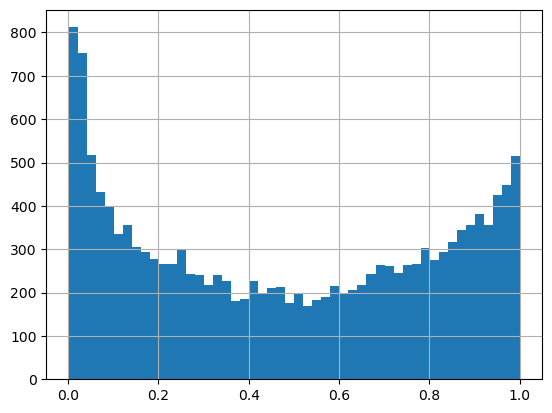

In [21]:
df_submission.probability.hist(bins=50)

In [22]:
df_submission.probability.min()

0.0017708122886688216

In [23]:
df_submission.probability.max()

0.9999445378780365